# Music Through the Decades

### Intro 
As I'm typing this introduction, I'm bopping to "Holiday" by Green Day, on a random "Pump Up Music" playlist that I found 5 minutes ago (thank you apache_king!). Music has played and continues to play a very important part of my life. I've been jamming to something or the other since first grade, learned to play the guitar in second grade, and have been in every band I possibly could throughout elementary, middle, and high school. Ever since starting college, I've gone to over 10 different concerts, and much to my roommates' consternation, every time I shower I blare anything from Imagine Dragons to Logic to Linkin Park to Queen (and badly sing to it). 

Needless to say, music is important to me. It's how I process my emotions when I'm upset, motivate myself when I feel lazy, and run the extra 3 minutes (because running the extra mile is too much to ask for) when I'm sweating it out at the gym. I'm sure I'm not the only one like this either. The emotions of a generation are forever captured by the popularity of songs of that time. Music has come to define eras and decades, like the psychedlic rock of the Beatles dominating the 60s, the eccentric theatric rock of Queen of the 80s, and even artists like NSYNC coming to embody the odd time that was the 90s. 

### Goals of the Project
We thought it would be interesting to see if there were changes between the popular music of the decades from the 50s through the 2010s. With every generation facing a different landscape, from the post-war economic boom in the 50s to recession in the late 2000s, we thought it would be interesting to explore whether changes in music reflected that. Would the uncertainty of a war with Russia in the 80s drive people to seek out more angry or sad music? Would the happiness after the end of World War 2 be reflected in the popularity of the songs in that era? By that token, by analyzing the popular songs of these decades, can we build a classifier that could predict the era a song was created in based off of its audio features? 

### How We Will Do This
Using Spotify and Genius's Web APIs, we wanted to explore these questions and present a case study in the changes in popular music over the decades. We will use Spotify's own "All Out" playlists, which are organized by decade. We felt that these playlists would prove a promising source of information about the popular songs of a certain decade. We will use Spotify's API to be able to gain information about the features of the track, from danceability to 'speechiness'. 

## Step One : Imports
The first thing we did was import everything that we needed. Because we were accessing the Spotify and Genius APIs, we use the requests library as well as others to be able to parse the information we query into a dataframe. There is a spotify library for python called spotipy, but we realized that there was not huge benefit from using that library instead of just using requests and get calls to the API endpoint. We will also later use the Natural Language ToolKit (or NLTK) to meaningfully analyze text, so we download the necessary modules from within that as well. Lastly, for preliminary machine learning, we also imported different modules within SciKit-Learn. 


In [6]:
# Request / Parsing 
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import string

#Visualization and EDA 
import sys 
# The below 3 statements were only done because we were coding within a Jupyter notebook set up for our class (CMSC320). 
# For those following at home, you will likely just need to pip install these in your command-line, instead of within 
# the confines of the notebook itself. 

!{sys.executable} -m pip install Pillow  
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install -U nltk
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns

#Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing
from sklearn import metrics

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: nltk in /opt/conda/lib/python3.6/site-packages
Requirement already up-to-date: six in /opt/conda/lib/python3.6/site-packages (from nltk)
Requirement already up-to-date: singledispatch in /opt/conda/lib/python3.6/site-packages (from nltk)
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## STEP 2: Gaining Access to the Spotify and Genius Web APIs 
To be able to continue with this project, you need authentification tokens provided through Spotify. We would periodically request tokens from this website : https://developer.spotify.com/console/get-playlist-tracks/?playlist_id=37i9dQZF1DX5Ejj0EkURtP&market=&fields=&limit=&offset= to query Spotify. This requires a Spotify account. Similarly, Genius's API requires an account as well. We used this website: https://docs.genius.com/#/getting-started-h1 to set up our own accounts. 

Afterwards, store the tokens within variables. 

In [7]:
# https://developer.spotify.com/console/get-playlist-tracks/?playlist_id=37i9dQZF1DX5Ejj0EkURtP&market=&fields=&limit=&offset= 
# use above website to generate token
token = "BQBHofH0ofj5PCnzD0he_SNu8ct2FpJVbnPsNs0Pg5SLfwAsDdNn64Mg7-NhJwp1-SzPKdPIjMmq4u_BqjAY4FbHQeh9OnRAhAjQabPlm4ukIFdrYBm0S-o1wlK37u75zXY_SOE8pV6xSeh2EQ"
# https://genius.com/api-clients ==> use this website to generate token
genius_token = 'V3BxSvKtWKcSlonUDfqeKWZmRKK3qjGyAGJCRqxm8awvuWI65nm7WFrYmnn3acIu'

# token = "INSERT SPOTIFY TOKEN HERE"
# genius_token = "INSERT GENIUS TOKEN HERE"

## STEP 3: Getting the Information Into a Dataframe
We used two different endpoints to get the necessary data to analyze the trends over time. The first one was to grab the decades playlist provided by Spotify from the 50s to the 2010s. These playlists list the most popular songs of the decade.

In [8]:
r_10s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX5Ejj0EkURtP", headers={'Authorization': 'Bearer ' + token})
r_00s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX4o1oenSJRJd", headers={'Authorization': 'Bearer ' + token})
r_90s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DXbTxeAdrVG2l", headers={'Authorization': 'Bearer ' + token})
r_80s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DX4UtSsGT1Sbe", headers={'Authorization': 'Bearer ' + token})
r_70s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DWTJ7xPn4vNaz", headers={'Authorization': 'Bearer ' + token})
r_60s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DXaKIA8E7WcJj", headers={'Authorization': 'Bearer ' + token})
r_50s = requests.get("https://api.spotify.com/v1/playlists/37i9dQZF1DWSV3Tk4GO2fq", headers={'Authorization': 'Bearer ' + token})


### Parsing the Data
We had to get the data into a form that is more readily understandable. The data returned from the playlist endpoint is in JSON format and many important data points very nested inside the JSON object. The code below is grabbing the important data from the JSON returned from each call to the API, grabbing those nested data points as well, and converting it into multiple dataframes. This shows the results for the 2010s playlist. We then replicated it for all of the other decades.

In [9]:
json_data = r_10s.json()
playlists_10 = json_normalize(json_data["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_10 = playlists_10.drop(columns=['external_urls', 'href', 'type', 'uri'])

playlists_10

,id,name,added_at,track.popularity,track.id,track.name,track.duration_ms
0,4UXqAaa6dQYAk18Lv7PEgX,Fall Out Boy,2018-12-01T17:58:03Z,62,3x7NGlfDKQYN2wnwEnL7r9,The Kids Aren't Alright,260920
1,3NPpFNZtSTHheNBaWC82rB,X Ambassadors,2018-12-01T17:58:03Z,76,7lGKEWMXVWWTt3X71Bv44I,Unsteady,193546
2,10exVja0key0uqUkk6LJRT,Vance Joy,2018-12-01T17:58:03Z,56,7lrDNvF3TwuC5vC2fGiMjy,Mess Is Mine,223640
3,4BxCuXFJrSWGi1KHcVqaU4,Kodaline,2018-12-01T17:58:03Z,69,2PwXOevGUSkU8qaYZjgLq2,All I Want,305746
4,246dkjvS1zLTtiykXe5h60,Post Malone,2018-12-01T17:58:03Z,86,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,223346
5,536BYVgOnRky0xjsPT96zl,Two Door Cinema Club,2018-12-01T17:58:03Z,68,1qfYG2JrchEyJiqKnkE7YQ,What You Know,189693
6,2WzaAvm2bBCf4pEhyuDgCY,Ruth B.,2018-12-01T17:58:03Z,76,4h0zU3O9R5xzuTmNO7dNDU,Lost Boy,275280
7,10exVja0key0uqUkk6LJRT,Vance Joy,2018-12-01T17:58:03Z,28,6uEIbSu5Omm6Rg2hcVrfJH,Georgia,230506
8,7Ln80lUS6He07XvHI8qqHH,Arctic Monkeys,2018-12-01T17:58:03Z,75,086myS9r57YsLbJpU0TgK9,Why'd You Only Call Me When You're High?,161123
9,58MLl9nC29IXbE4nEtuoP2,Alex & Sierra,2018-12-01T17:58:03Z,78,1almCHdsfikRPfVB9VrEdT,Little Do You Know,185200


In [10]:
json_data = r_10s.json()
playlists_10 = json_normalize(json_data["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_10 = playlists_10.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_00 = r_00s.json()
playlists_00 = json_normalize(json_data_00["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_00 = playlists_00.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_90 = r_90s.json()
playlists_90 = json_normalize(json_data_90["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_90 = playlists_90.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_80 = r_80s.json()
playlists_80 = json_normalize(json_data_80["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_80 = playlists_80.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_70 = r_70s.json()
playlists_70 = json_normalize(json_data_70["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_70 = playlists_70.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_60 = r_60s.json()
playlists_60 = json_normalize(json_data_60["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_60 = playlists_60.drop(columns=['external_urls', 'href', 'type', 'uri'])

json_data_50 = r_50s.json()
playlists_50 = json_normalize(json_data_50["tracks"]["items"], [['track', 'artists']], ['added_at', ['track', 'popularity'], ['track', 'id'], ['track', 'name'], ['track', 'duration_ms']], errors='ignore')
playlists_50 = playlists_50.drop(columns=['external_urls', 'href', 'type', 'uri'])

playlists_80

,id,name,added_at,track.popularity,track.id,track.name,track.duration_ms
0,0PFtn5NtBbbUNbU9EAmIWF,Toto,2018-12-01T18:05:10Z,66,5tJjo5JDF9zhzYD7yQfATH,Africa,296000
1,4QTVePrFu1xuGM9K0kNXkk,Dexys Midnight Runners,2018-12-01T18:05:10Z,28,5uzNa0SBGOe5pPnstWHMCt,Come On Eileen,273720
2,77tT1kLj6mCWtFNqiOmP9H,Daryl Hall & John Oates,2018-12-01T18:05:10Z,76,4o6BgsqLIBViaGVbx5rbRk,You Make My Dreams,190626
3,6zFYqv1mOsgBRQbae3JJ9e,Billy Joel,2018-12-01T18:05:10Z,74,5zA8vzDGqPl2AzZkEYQGKh,Uptown Girl,197706
4,6IFXsrXBpwbIqtOUOiAa3p,Rick Springfield,2018-12-01T18:05:10Z,60,2F1fnE1a8zQCogM6jJifHH,Jessie's Girl,194266
5,4bthk9UfsYUYdcFyqxmSUU,Tears For Fears,2018-12-01T18:05:10Z,78,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,251488
6,3RGLhK1IP9jnYFH4BRFJBS,The Clash,2018-12-01T18:05:10Z,76,39shmbIHICJ2Wxnk1fPSdz,Should I Stay or Should I Go - Remastered,188986
7,6H1RjVyNruCmrBEWRbD0VZ,Def Leppard,2018-12-01T18:05:10Z,16,5L4kmSZOSjaoUEzrFqQadT,Pour Some Sugar On Me,267306
8,2jzc5TC5TVFLXQlBNiIUzE,a-ha,2018-12-01T18:05:10Z,81,2WfaOiMkCvy7F5fcp2zZ8L,Take On Me,225280
9,0rvjqX7ttXeg3mTy8Xscbt,Journey,2018-12-01T18:05:10Z,67,71SvEDmsOwIWw1IozsZoMA,Any Way You Want It,201693


### Getting the Music Attributes
Now that we have the information about each playlist, we want to grab information for each track inside the playlists. The code below makes a list of all the track ids in the playlists and uses that to call to the second end point we use: the audio features end point. This end point will give a good amount of information such, the valence, the tempo, the danceability, the instrumentalness, the speechiness, and the energy of each of the songs in the playlist and convert it into a dataframe. However, this endpoint will also give us unnecessary information such as the mode, track_href, uri, and analysis url of the song, which is not useful for our analysis. 

In [11]:
aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
df_new = playlists_10.groupby(playlists_10['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_00 = playlists_00.groupby(playlists_00['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_90 = playlists_90.groupby(playlists_90['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_80 = playlists_80.groupby(playlists_80['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_70 = playlists_70.groupby(playlists_70['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_60 = playlists_60.groupby(playlists_60['track.name']).aggregate(aggregation_functions)

aggregation_functions = {'name': 'first', 'track.id': 'first', 'track.duration_ms': 'first', 'added_at': 'first', 'track.popularity' : 'first'}
grouped_50 = playlists_50.groupby(playlists_50['track.name']).aggregate(aggregation_functions)


In [12]:
track_ids = df_new['track.id'].tolist()
track_str = '%2C'.join(track_ids)
t = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str, headers={'Authorization': 'Bearer ' + token})
track_info_df = json_normalize(t.json()['audio_features'])
track_info_df = track_info_df.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_00 = grouped_00['track.id'].tolist()
track_str_00 = '%2C'.join(track_ids_00)
t_00s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_00, headers={'Authorization': 'Bearer ' + token})
track_info_00 = json_normalize(t_00s.json()['audio_features'])
track_info_00 = track_info_00.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_90 = grouped_90['track.id'].tolist()
track_str_90 = '%2C'.join(track_ids_90)
t_90s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_90, headers={'Authorization': 'Bearer ' + token})
track_info_90 = json_normalize(t_90s.json()['audio_features'])
track_info_90 = track_info_90.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_80 = grouped_80['track.id'].tolist()
track_str_80 = '%2C'.join(track_ids_80)
t_80s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_80, headers={'Authorization': 'Bearer ' + token})
track_info_80 = json_normalize(t_80s.json()['audio_features'])
track_info_80 = track_info_80.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_70 = grouped_70['track.id'].tolist()
track_str_70 = '%2C'.join(track_ids_70)
t_70s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_70, headers={'Authorization': 'Bearer ' + token})
track_info_70 = json_normalize(t_70s.json()['audio_features'])
track_info_70 = track_info_70.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_60 = grouped_60['track.id'].tolist()
track_str_60 = '%2C'.join(track_ids_60)
t_60s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_60, headers={'Authorization': 'Bearer ' + token})
track_info_60 = json_normalize(t_60s.json()['audio_features'])
track_info_60 = track_info_60.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

track_ids_50 = grouped_50['track.id'].tolist()
track_str_50 = '%2C'.join(track_ids_50)
t_50s = requests.get("https://api.spotify.com/v1/audio-features?ids=" + track_str_50, headers={'Authorization': 'Bearer ' + token})
track_info_50 = json_normalize(t_50s.json()['audio_features'])
track_info_50 = track_info_50.drop(columns=['analysis_url', 'mode', 'track_href', 'type', 'uri'])

#track.name appears to be in the index so we need to reindex it
grouped_50_index = grouped_50.index
grouped_50.index = range(len(grouped_50))
grouped_50["track.name"] = grouped_50_index

grouped_60_index = grouped_60.index
grouped_60.index = range(len(grouped_60))
grouped_60["track.name"] = grouped_60_index

grouped_70_index = grouped_70.index
grouped_70.index = range(len(grouped_70))
grouped_70["track.name"] = grouped_70_index

grouped_80_index = grouped_80.index
grouped_80.index = range(len(grouped_80))
grouped_80["track.name"] = grouped_80_index

grouped_90_index = grouped_90.index
grouped_90.index = range(len(grouped_90))
grouped_90["track.name"] = grouped_90_index

grouped_00_index = grouped_00.index
grouped_00.index = range(len(grouped_00))
grouped_00["track.name"] = grouped_00_index

df_index = df_new.index
df_new.index = range(len(df_new))
df_new["track.name"] = df_index

print(grouped_50)

                             name                track.id  track.duration_ms  \
0         Bill Haley & His Comets  5PZf7EZr7GfkOAgeEcsqPa             134106   
1             Dion & The Belmonts  6AhHYWJOBMRjEi2z1tWpYa             153866   
2                     Fats Domino  4ZfQwNx3FlCN07cnUvekh3             152200   
3             Danny & The Juniors  6vkuJbGjyjnSQReeaCh8wT             149933   
4                     The Regents  0Aoh3SQxGdBlxVSXLZUToj             135773   
5    Gene Vincent & His Blue Caps  0TMrV95mP7sDlvbE4iVfKP             157206   
6                     Fats Domino  2NkAoxQOr6MGdMB5JDTU81             143440   
7                   The Monotones  6kIYy84YuKk2dwAZbYJjrG             138986   
8                     Louis Prima  7LYfx4uOewuMJnkAN4xHlj             180093   
9             The Everly Brothers  0xK34uEDBKa9ZzJ6kelLJE             142906   
10                  Eddie Cochran  3kEnKwF8IbvTwUuubZb17q             117666   
11                The Del-Vikings  4Ul2q

Now we have two groups of dataframes: the dataframes with each decade's playlist information, and the dataframes with all the song information for each decade. Now we want to merge the on a common columns between the two which would be the track id column.

In [13]:
data_2010s = pd.merge(df_new, track_info_df, left_on = 'track.id', right_on = 'id')
data_2000s = pd.merge(grouped_00, track_info_00, left_on = 'track.id', right_on = 'id')
data_1990s = pd.merge(grouped_90, track_info_90, left_on = 'track.id', right_on = 'id')
data_1980s = pd.merge(grouped_80, track_info_80, left_on = 'track.id', right_on = 'id')
data_1970s = pd.merge(grouped_70, track_info_70, left_on = 'track.id', right_on = 'id')
data_1960s = pd.merge(grouped_60, track_info_60, left_on = 'track.id', right_on = 'id')
data_1950s = pd.merge(grouped_50, track_info_50, left_on = 'track.id', right_on = 'id')

We now want to add another column named decade to be able to differentiate between the different decades when we combine all dataframes into one large dataframe with all the information

In [14]:
data_2010s['decade'] = '2010s'
data_2000s['decade'] = '2000s'
data_1990s['decade'] = '1990s'
data_1980s['decade'] = '1980s'
data_1970s['decade'] = '1970s'
data_1960s['decade'] = '1960s'
data_1950s['decade'] = '1950s'

# In the code below, we combine all the dataframes into one large dataframe
decades_data = pd.concat([data_2010s, data_2000s, data_1990s, data_1980s, data_1970s, data_1960s, data_1950s])
decades_data['energy'].groupby(decades_data['decade']).describe()
# fixing the index
decades_data.index = range(len(decades_data))
decades_data.head()


,name,track.id,track.duration_ms,added_at,track.popularity,track.name,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,decade
0,Paramore,1j8z4TTjJ1YOdoFEDwJTQa,296520,2018-12-01T17:58:03Z,70,Ain't It Fun,0.154,0.610,296520,0.893,1j8z4TTjJ1YOdoFEDwJTQa,0.000044,9,0.0210,-3.681,0.0921,104.031,4,0.673,2010s
1,B.o.B,6lV2MSQmRIkycDScNtrBXO,180480,2018-12-01T17:58:03Z,72,Airplanes (feat. Hayley Williams),0.110,0.660,180480,0.867,6lV2MSQmRIkycDScNtrBXO,0.000000,6,0.0368,-4.285,0.1160,93.033,4,0.377,2010s
2,Kodaline,2PwXOevGUSkU8qaYZjgLq2,305746,2018-12-01T17:58:03Z,69,All I Want,0.172,0.209,305747,0.412,2PwXOevGUSkU8qaYZjgLq2,0.150000,0,0.0843,-9.733,0.0443,86.260,3,0.162,2010s
3,Snakehips,6TaqooOXAEcijL6G1AWS2K,229746,2018-12-01T17:58:03Z,72,All My Friends (feat. Tinashe & Chance the Rap...,0.119,0.689,229747,0.521,6TaqooOXAEcijL6G1AWS2K,0.000084,0,0.1080,-5.845,0.1320,95.055,4,0.178,2010s
4,Niykee Heaton,3rvLfPT9sm9UPeIr8OQA65,245722,2018-12-01T17:58:03Z,12,Bad Intentions,0.223,0.744,245723,0.722,3rvLfPT9sm9UPeIr8OQA65,0.000000,11,0.0960,-5.140,0.0778,124.008,4,0.393,2010s


### Some Exploratory Data Analysis
The following code gives a visualization of the trends in the different aspects of music using the averages in the large dataframe over the different audio features of the tracks.  

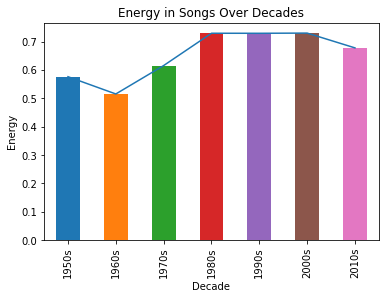

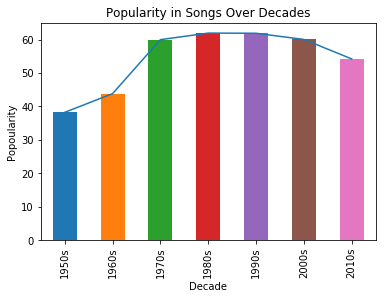

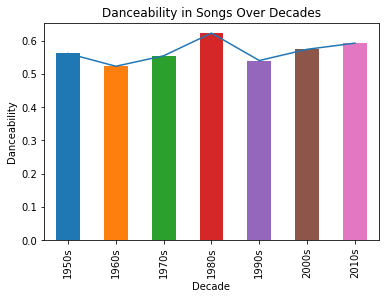

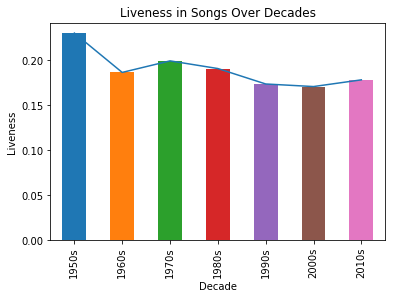

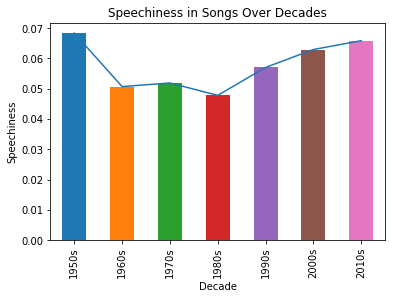

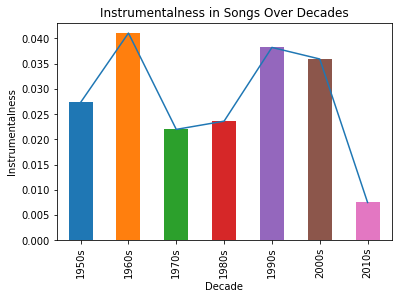

In [15]:
classes = ["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]

decades_data['energy'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['energy'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Energy')
plt.xlabel('Decade')
plt.title('Energy in Songs Over Decades')
plt.show()

decades_data['track.popularity'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['track.popularity'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Popoularity')
plt.xlabel('Decade')
plt.title('Popularity in Songs Over Decades')
plt.show()

decades_data['danceability'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['danceability'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Danceability')
plt.xlabel('Decade')
plt.title('Danceability in Songs Over Decades')
plt.show()

decades_data['liveness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['liveness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Liveness')
plt.xlabel('Decade')
plt.title('Liveness in Songs Over Decades')
plt.show()

decades_data['speechiness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['speechiness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Speechiness')
plt.xlabel('Decade')
plt.title('Speechiness in Songs Over Decades')
plt.show()

decades_data['instrumentalness'].groupby(decades_data['decade']).mean().plot(kind='line')
decades_data['instrumentalness'].groupby(decades_data['decade']).mean().plot(kind='bar')
plt.ylabel('Instrumentalness')
plt.xlabel('Decade')
plt.title('Instrumentalness in Songs Over Decades')
plt.show()


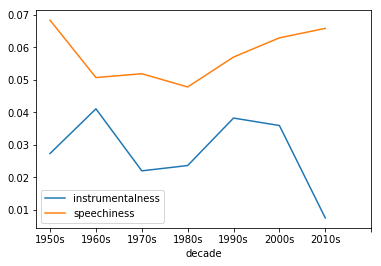

In [16]:
# This is comparing the instrumentalness to the liveness of the music, to see whether there appears to be an inverse 
# relation between the two

test = decades_data['instrumentalness'].groupby(decades_data['decade']).mean().to_frame()
test["liveness"] = decades_data['liveness'].groupby(decades_data['decade']).mean()
test["energy"] = decades_data['energy'].groupby(decades_data['decade']).mean()
test["popularity"] = decades_data['track.popularity'].groupby(decades_data['decade']).mean()
test["danceability"] = decades_data['danceability'].groupby(decades_data['decade']).mean()
test["speechiness"] = decades_data['speechiness'].groupby(decades_data['decade']).mean()
test['duration_ms'] = decades_data['duration_ms'].groupby(decades_data['decade']).mean()

test.plot.line(y=['instrumentalness', 'speechiness'])
plt.xticks([0,1,2,3,4,5,6, 7], test.index.values.tolist())
plt.show()

### Visualizing each Decade's Profile
Spotify's API gives us a number of features to characterize a track by. To name a few metrics that Spotify tracks for each song, you could find out the level of acousticness, loudness, tempo, and regularity for a particular track. All of these audio features play an essential part in the unique make up for a track and it would be good to start off our data analysis with a big picture of how songs in each decade compares to each other overall. We decided to create radar charts to chart a few key measures that we felt were interesting and could characterize the popular songs from each decade. 

Each decade's profile is in the form of a radar chart that gives the average energy, speechiness, instrumentalness, danceability, and liveness for the popular songs of a certain decade.

Energy, speechiness, valence, danceability, and instrumentalness are all values on a scale from 0 to 1. Energy describes the intensity of a track. Tracks with high energy feel fast, loud, or noisy. Speechiness describes the presence of spoken words in a track. Valence describes the positiveness that is conveyed by a track. High valence is an indication of a happier song while low valence is an indication of a more sad or angry song, Danceability describes how suitable a track is for dancing using musical elements like temp, beat strength, and regularity. Instrumentalness describes the degree to which a song has no vocals.

We produced radar charts for each decade starting from the 1950s up to the 2010a, each giving a general overview of how each audio feature's performance makes up a song of a decade in a wholistic evaluation.


In [17]:

### Creating a Radar Chart for the metrics of the average song in a particular decade
mean_stats = pd.DataFrame()

# Obtaining mean for each metric for all the popular songs in a decade
mean_stats['energy'] = decades_data['energy'].groupby(decades_data['decade']).mean()
mean_stats['speechiness'] = decades_data['speechiness'].groupby(decades_data['decade']).mean()
mean_stats['instrumentalness'] = decades_data['instrumentalness'].groupby(decades_data['decade']).mean()
mean_stats['danceability'] = decades_data['danceability'].groupby(decades_data['decade']).mean()
mean_stats['valence'] = decades_data['valence'].groupby(decades_data['decade']).mean()


# Standardizing all the metrics so they can be scaled relative to each other in the 
# radar chart
for name, values in mean_stats.iteritems():
    mean = values.mean()
    std1 = values.std()
    mean_stats[name] = (values - mean)/std1

mean_stats


,energy,speechiness,instrumentalness,danceability,valence
decade,,,,,
1950s,-0.896221,1.312825,-0.053250,-0.165287,1.616120
1960s,-1.603744,-0.881296,1.125767,-1.318540,0.146751
1970s,-0.439697,-0.733933,-0.512158,-0.373636,0.309915
1980s,0.883516,-1.241344,-0.372021,1.676536,0.729579
1990s,0.881940,-0.096749,0.881961,-0.802544,-0.712150
2000s,0.890139,0.639633,0.685194,0.212385,-0.892421
2010s,0.284068,1.000862,-1.755494,0.771086,-1.197795


Now, python itself does not have built in functionalities that create radar charts. Luckily, we were able to create radar charts following this tutortial from Kaggle. 

    Draw a Radar Chart with Python in a Simple Way
    by Chen ShuyaoDraw
    (https://www.kaggle.com/typewind/draw-a-radar-chart-with-python-in-a-simple-way)

You can follow it too and create your own radar charts in performance analysis,

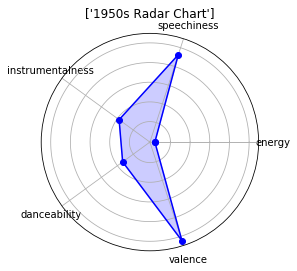

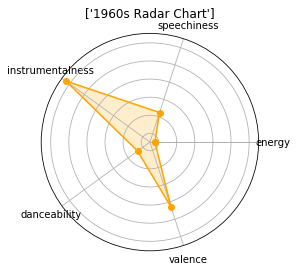

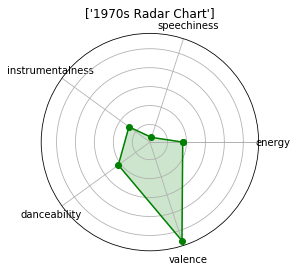

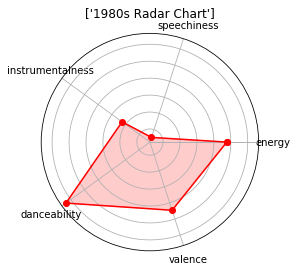

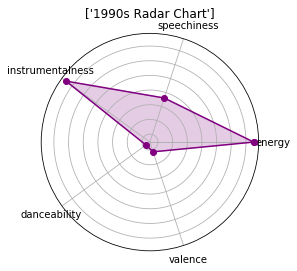

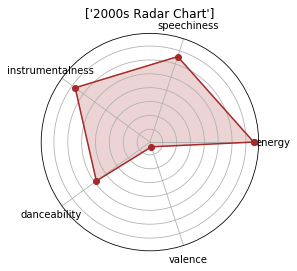

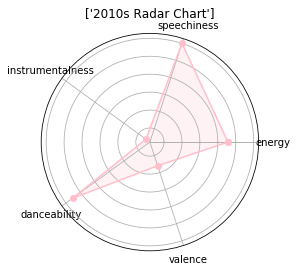

In [18]:
# Creating the radar charts
labels=np.array(['energy', 'speechiness', 'instrumentalness', 'danceability', 'valence'])
colors=np.array(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink'])

for i in range(7):
    # sets up the axes
    stats=mean_stats.iloc[i].values
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # creates a closed plot
    angles=np.concatenate((angles,[angles[0]]))
    stats=np.concatenate((stats,[stats[0]]))
    fig=plt.figure()
    
    # when adding a subplot, make the polar parameter True to plot the subplot on
    # the radial axes
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, '-o', color = colors[i])
    ax.fill(angles, stats, alpha=0.2, color = colors[i])
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title([mean_stats.index[i] + " Radar Chart"])
    ax.set_yticklabels([])
    ax.grid(True)


The final radar charts produced allows us to visualize a profile of energy, liveness, danceability, instrumentalness, and speechiness for the popular songs of each decade. The changes in shape across the decades reveal several distinct similaries and differences in track structure and musical content from the 1950s to the 2010s.

One can immediately group some of the decades in this period together due to the similar shape of their profiles. The shape of 1950s and 1960s profiles are very similar. For both the 1950s and the 1960s, tracks had high instrumentalness and valence, medium speechiness and energy (energy is lower for 1960s), and low danceability. Then in the 1970s, speechiness drops considerably while danceability and energy become more pronounced. The 1970s have high instrumentalness and valence, medium energy and danceability, and low speechiness. 

The transition between the 1970s and 1980s shows a significant change in the track structure and audio features of popular songs. There is a drop in instrumentalness and valence and there is an increase in energy and danceability. The 1980s specifically had high energy and danceability, medium instrumentalness and valence, and low speechiness. Medium/low instrumentalness and valence and medium/high energy and danceability will persist for the decades after the 1980s. 

The shapes of the radar charts for the 1990s, 2000s, and 2010s are similar. The three decades all have low instrumentalness and valence and high energy and danceability. The 1990s had a low speechiness while the 2000s and 2010s had high speechiness. The profile shape for the 2000s and 2010s are almost indiscernible.



### Trending Danceability, Speechiness, and Energy across the Decades
How exactly do we know that a song is popular? Spotify and other radio often curate these lists based on the how often the song was played amongst various media outlets. We imagined the types of occasions that we, as general music consumers, like to play music at and what makes a song so catchy or fitting for singing along to in the car or swaying those hips at dance functions. Perhaps there is some relationship between the danceability, speechiness, and energy of songs across the decades.

We created a scatterplot to compare the danceability, speechiness, and energy of songs from the 1950s to the 2010s. Energy, the intensity of a track, varies along the y axis. Danceability is noted by the hue of the color blue. Light blue means the track is of low danceability while dark blue means the track is of high danceability. Speechiness, the presence of spoken words in a track, is marked by the size of the data point. Bigger data points indicate that the track has more spoken words than tracks marked by smaller data points.

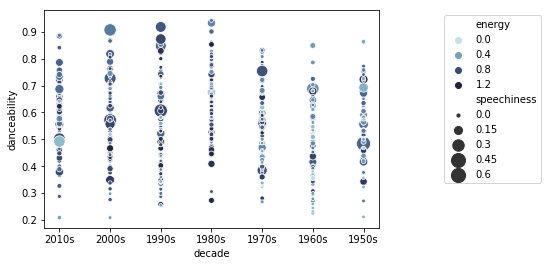

In [19]:
# Creating a scatterplot for 4 variables
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="decade", y="danceability",
                     hue="energy", size="speechiness",
                     palette=cmap, sizes=(10, 200),
                     data=decades_data)
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5, 0.5, 0.5))



Over the decades, the danceability of popular tracks have increased as there is a slight upward movement in the range of danceability for tracks over time. The 2000s stands out as the decade with the most speechiness and energy since its plots have some of the largest and darkest data points. In contrast, the 1960s stands out as the decade with popular tracks that have the lowest energy and speechiness due to the light color and small size of its data points.


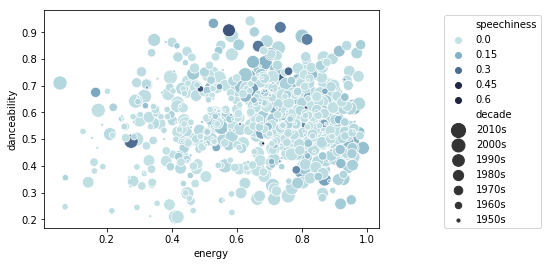

In [20]:
##pretty but don't use

ax = sns.scatterplot(x="energy", y="danceability",
                     hue="speechiness", size="decade",
                     palette=cmap, sizes=(10, 200),
                     data=decades_data)
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5, 0.5, 0.5))